# Strategy details:

Reference: Sahil Teymurzade & Robert Ślepaczuk, 2023. "Predicting DJIA, NASDAQ and NYSE index prices using ARIMA and VAR models," Working Papers 2023-27, Faculty of Economic Sciences, University of Warsaw.

Link to reference: https://ideas.repec.org/p/war/wpaper/2023-27.html

The main idea: Stock forecasting with ARIMA or VAR models.

### My 2 cents on the matter:
Personally, I have never seen ARIMA or VAR models work. They usually work on stationary data. But the stock market prices is highly non-stationary and even differencing wouldn't help much. In the lower quality papers, specially the ones in the engineering area, some authors use r-squared, mean squared errors, or similar metrics to claim they have a good model. Well, if you use a simple moving average, you get an r-squared of more than 95% for the prices, not the returns. A more advanced model would be using LSTM to do such thing, but again, the problem

### What I won't do as what the paper has done?
- The paper does an optimization on the p, q, d of ARIMA model. I won't do it, because based on my personal experience, it won't change the results that much. I will simply use ARIMA (2,2,2)
- The paper tries to find the optimal lag by using AIC to find the best VAR model. I will simply use 5 days, 10 days, 22 days, and 66 days. We can see the results for all of them.
- The paper accounts for transaction costs. I will simply see of the absolute value of the forecast will return more than 10 bps. That will be my assumption for transaction costs.
- There are many parts in the paper that is ambiguous to me. For example, the paper claims that they use the first 500 days as the training, but they still have trading results over the first 2 years of the paper. Either, I am missing something, or they should start their simulation after the first 2 years.

Let's do it anyway. It will be a good sample for ARIMA codes. At least I hope.

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

start_date = '2000-11-30' # Same as the paper
end_date = '2020-11-30' # Same as the paper
tickers = ['^DJI', '^IXIC', '^NYA']

In [29]:
# Load the data
def download_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')
    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2024-5-31')
        df.to_csv(file_name)

for i, symbol in enumerate(tickers):
    print (f'Loading data for {symbol} ({i+1}/{len(tickers)})', end='\r')
    download_data(symbol)

print (f'Loaded data for {len(tickers)} companies')

Loaded data for 3 companies)


In [30]:
def process_data(symbol):

    df = pd.read_csv(f'data/{symbol}.csv', index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')

    df = df[['Open', 'Close']]

    # Adding the returns
    df['returns'] = df['Close'].pct_change()
    df['next_day_return'] = df['returns'].shift(-1)

    # Assuming that we will open position tomorrow at the opening price
    df['next_day_return_intraday'] = (df['Close'] / df['Open'] - 1).shift(-1)

    # Adding the 5-day exponential moving average
    df['5d_ema_pred'] = df['Close'].ewm(span=5, adjust=False).mean().shift()

    # Lagging the returns for the VAR model
    for i in range (67):
        df[f'return_lag_{i}'] = df['returns'].shift(i)

    return df

holder = {}
for i, symbol in enumerate(tickers):
    print (f'Processing data for {symbol} ({i+1}/{len(tickers)})', end='\r')
    holder[symbol] = process_data(symbol)

In [31]:
# Doing the VAR model first
look_back_period = 500
for symbol, df in holder.items():
    for target_lag in [5, 10, 22, 66]:

        cols = [f'return_lag_{i}' for i in range(target_lag)]
        
        df[f'VAR_pred_lag_{target_lag}'] = np.nan
        for i, idx in enumerate(df.index):

            if i < look_back_period:
                continue

            X = df[cols].iloc[i-look_back_period:i]
            Y = df['next_day_return'].iloc[i-look_back_period:i]

            model = sm.OLS(Y, X, missing='drop')
            results = model.fit()

            pred = results.predict(df[cols].iloc[i].values)

            df.at[idx, f'VAR_pred_lag_{target_lag}'] = pred

            if i % 100 == 0:
                print (f'VAR model for {symbol} with target lag {target_lag} ({i}/{len(df)})', end='\r')

    holder[symbol] = df

In [36]:
# Doing the ARIMA model
import warnings
warnings.filterwarnings("ignore")
from numpy.linalg import LinAlgError

look_back_period = 250
for symbol, df in holder.items():

    df[f'ARIMA_pred_{look_back_period}'] = np.nan
    for i, idx in enumerate(df.index):

        if i < look_back_period:
            continue

        X = df['Close'].iloc[i-look_back_period:i].values

        try:
            model = ARIMA(X, order=(2, 2, 2))
            model_fit = model.fit()

            pred = model_fit.get_forecast(steps=1).predicted_mean[0]
            df.at[idx, 'ARIMA_pred'] = pred
        
        except LinAlgError:
            df.at[idx, 'ARIMA_pred'] = df.at[idx, 'Close']

        if i % 100 == 0:
            print (f'ARIMA model for {symbol} ({i}/{len(df)})', end='\r')

    df['Expected_return_based_on_ARIMA'] = df['ARIMA_pred'] / df['Close'] - 1

    holder[symbol] = df

In [48]:
for symbol, df in holder.items():
    
    # For the VAR model
    for target_lag in [5, 10, 22, 66]:
        mask = df[f'VAR_pred_lag_{target_lag}'].abs() > 0.0010

        df[f'realized_return_VAR_lag_{target_lag}'] = np.nan
        df.loc[mask, f'realized_return_VAR_lag_{target_lag}'] = df.loc[mask, 'next_day_return_intraday'] * np.sign(df.loc[mask, f'VAR_pred_lag_{target_lag}'])
        df[f'realized_return_VAR_lag_{target_lag}'].fillna(0, inplace=True)

    # For the ARIMA model
    mask = df['Expected_return_based_on_ARIMA'].abs() > 0.0010
    df['realized_return_ARIMA'] = np.nan
    df.loc[mask, 'realized_return_ARIMA'] = df.loc[mask, 'next_day_return_intraday'] * np.sign(df.loc[mask, 'Expected_return_based_on_ARIMA'])
    df['realized_return_ARIMA'].fillna(0, inplace=True)

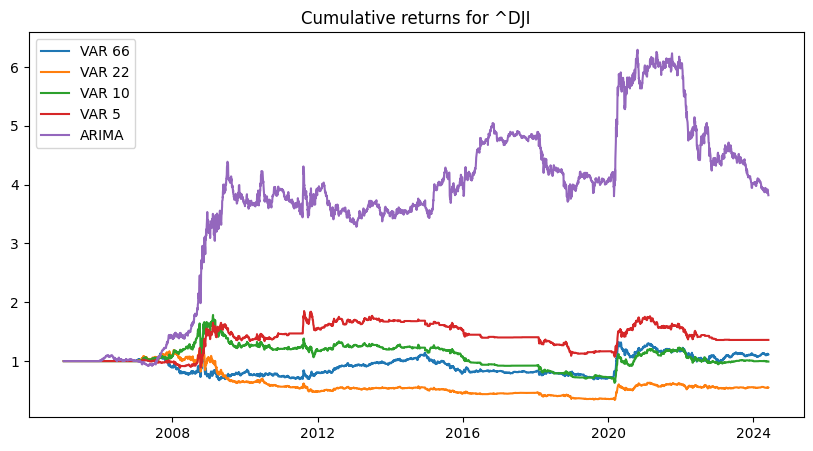

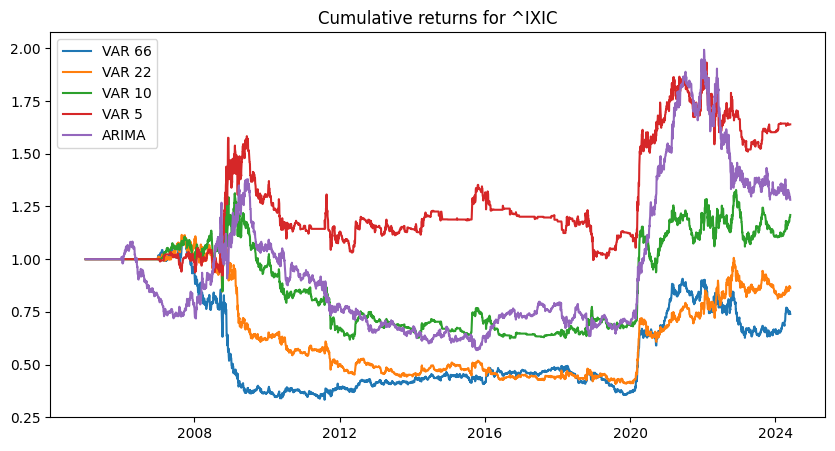

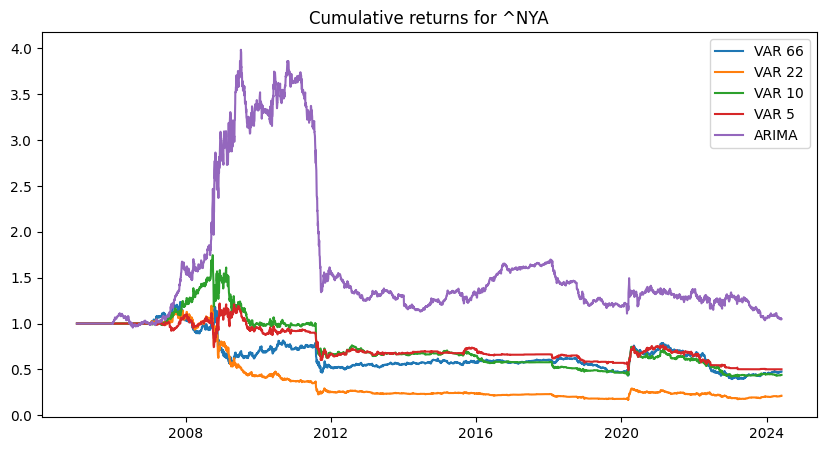

          VAR_5    VAR_10    VAR_22    VAR_66     ARIMA
^DJI   0.187358  0.063588 -0.141659  0.111706  0.515451
^IXIC  0.256273  0.140024  0.026367 -0.019521  0.160033
^NYA  -0.175677 -0.199322 -0.416771 -0.143000  0.101761


In [49]:
# Find the sharpe and plot the cumreturns
results_holder = {}
for symbol, df in holder.items():

    results = {}
    for target_lag in [5, 10, 22, 66]:
        realized_returns = df[f'realized_return_VAR_lag_{target_lag}']
        sharpe_VAR = np.sqrt(252) * realized_returns.mean() / realized_returns.std()
        results[f'VAR_{target_lag}'] = sharpe_VAR

    realized_returns = df['realized_return_ARIMA']
    sharpe_ARIMA = np.sqrt(252) * realized_returns.mean() / realized_returns.std()
    results['ARIMA'] = sharpe_ARIMA

    results_holder[symbol] = results

    # Plotting the cumulative returns
    df['cumulative_return_VAR_66'] = (1 + df['realized_return_VAR_lag_66']).cumprod()
    df['cumulative_return_VAR_22'] = (1 + df['realized_return_VAR_lag_22']).cumprod()
    df['cumulative_return_VAR_10'] = (1 + df['realized_return_VAR_lag_10']).cumprod()
    df['cumulative_return_VAR_5'] = (1 + df['realized_return_VAR_lag_5']).cumprod()
    df['cumulative_return_ARIMA'] = (1 + df['realized_return_ARIMA']).cumprod()

    plt.figure(figsize=(10, 5))
    plt.plot(df['cumulative_return_VAR_66'], label='VAR 66')
    plt.plot(df['cumulative_return_VAR_22'], label='VAR 22')
    plt.plot(df['cumulative_return_VAR_10'], label='VAR 10')
    plt.plot(df['cumulative_return_VAR_5'], label='VAR 5')
    plt.plot(df['cumulative_return_ARIMA'], label='ARIMA')
    plt.title(f'Cumulative returns for {symbol}')
    plt.legend()
    plt.show()
    plt.close()

results_holder = pd.DataFrame(results_holder).T
print (results_holder)

### Final thoughts

I don't see anything tradable here. Although we can see some good results on ARIMA for ^DJI, it's still very very unreliable to me. The details of the methodology that I used here is different, the results of the DJI is similar to the results of the paper. But the other results are not similar.

#### Source of discrepancy?
The biggest difference is that the paper calculates the results based on the today's Close, but I did the calculations based on tomorrow's open. This is a very very common technical mistake that a considerable number of academic papers do. Which is, they assume they can open at the daily close price, after finding out the exact value of the open price, feeding it into their model, and predicting the future.

#### What to do in these situations?
1- Use the 15:50 as the close price, conduct the analysis and place the order. The disadvantage is that with we need to do the simulation based on the 15:50 prices again and see if the results are good. Also, it's a technically hard thing to do in production.

2- Open at tomorrow's open price. But the results are not that enticing. There are some solutions to improve the results, but we are stepping into the proprietary information and cannot disclose more here.


#### Conclusion and personal thoughts?
Don't use these time series models. They don't work based on my limited experience.